<table>
    <tr>
        <td>
            <img src="extra/logo_scgis.png" width="100" height="100" />
        </td>
        <td>
            <center>
                <font size = 1>
                8 НОЯБРЯ 2020<br>
                АНТИКОНФЕРЕНЦИЯ СООБЩЕСТВА ПРИРОДООХРАННЫХ ГИС В РОССИИ<br><br>
                </font>
                <font size = 3>
                Материалы к вебинару<br> <b>Получение и обработка данных дистанционного зондирования с помощью Python:<br>строим простую систему мониторинга окружающей среды в Jupyter Notebook.</b><br><br>
                </font>
                <font size = 2>
                <b>Эдуард Казаков</b><br>
                NextGIS, Государственный гидрологический институт
                </font>
            </center>
        </td>
    </tr>
</table>

# Часть 2. Собираем всё вместе!

### Импортируем библиотеки, возможности которых нам будут необходимы

In [2]:
# Инструменты для работы с файловой системой
import os
# Библиотеки для работы с векторными и растровыми данными
import gdal, ogr
# Библиотека для взаимодействия с интернет-ресурсами
import requests
# Библиотека для разбора XML документов
import xml.etree.ElementTree as etree
# Библиотека для работы с датами и временем
from datetime import datetime
from datetime import timedelta
# Библиотека для работы с архивами
import zipfile
# Библиотека для построения графиков 
import matplotlib.pyplot as plt
# Библиотека для работы с матрицами
import numpy as np

In [3]:
# глобальная настройка
CLOUD_SEARCH_THRESHOLD = 30

### Объявляем функции по мотивам экспериментов

In [4]:
# Функция поиска данных S2
def search_s2 (user, password, start_date, end_date, region_file, cloud_limit=CLOUD_SEARCH_THRESHOLD):
    scenes = []
    
    region_ds = ogr.Open(region_file)
    region_layer = region_ds.GetLayerByIndex(0)
    region_feature = region_layer.GetFeature(0)
    region_wkt = region_feature.geometry().ExportToWkt()
    
    region_rule = '"Contains(%s)"' % region_wkt
    start_date = start_date.strftime("%Y-%m-%dT%H:%M:%SZ")
    end_date = end_date.strftime("%Y-%m-%dT%H:%M:%SZ")
    cloud = '[0 TO %s]' % cloud_limit
    platform = 'Sentinel-2'
    product = 'S2MSI2A'
    
    query = 'https://scihub.copernicus.eu/dhus/search?q=(platformname:%s) AND (producttype:%s) AND (footprint:%s) AND (beginposition:[%s TO %s]) AND (endposition:[%s TO %s]) AND (cloudcoverpercentage:%s)&rows=100' % (platform, product, region_rule, start_date, end_date, start_date, end_date, cloud)
    print ('Запрос:')
    print (query)
    print ('Начинаем поиск...')
    r = requests.get(query, auth=(user,password))
    
    answer_data = etree.ElementTree(etree.fromstring(r.content)).getroot()
    entries = answer_data.findall('{http://www.w3.org/2005/Atom}entry')
    
    for entry in entries:
        uuid = None
        filename = None
        for child in entry:
            if (child.get('name') == 'uuid'):
                uuid = child.text

            if (child.get('name') == 'filename'):
                filename = child.text
                
        if (not uuid) or (not filename):
            continue
        
        scenes.append({'filename': filename,
                       'uuid': uuid})
    return scenes

In [5]:
# Функция загрузки данных S2
def download_s2_by_uuid (user, password, uuid, destination):
    if os.path.exists(destination):
        print ('Файл уже существует')
        return
    
    current_size = 0
    chunk_size = 4096
    
    odata_base_url = 'https://scihub.copernicus.eu/dhus/odata/v1/'
    downloader_string = odata_base_url + 'Products(\'%s\')/$value' % str(uuid)
    r = requests.get(downloader_string, auth=('spbgeotex','SpbGeoTex0'), stream=True)
    
    print ('Начинаем загрузку %s' % destination)
    with open(destination, 'wb') as fd:
        k = 0
        for chunk in r.iter_content(chunk_size=chunk_size):
            # Чтобы быть в курсе процесса, печатаем прогресс, но не каждый раз, а при загрузке каждой 20000 пачки
            if k % 20000 == 0:
                print ('Megabytes downloaded: %s\r' % str(current_size / 1024 / 1024.0))
            k += 1

            fd.write(chunk)
            current_size += chunk_size

In [14]:
# На основе двух предыдущих создадим функцию, которая будет скачивать и разархивировать все новые данные
def download_new_datasets(user, password, region_file, start_date, raw_scenes_dir, processed_dir):
    # План:
    # 1. Определить дату, на которую скачан последний снимок
    # 2. Найти все новые снимки начиная с этой даты
    # 3. Скачать их и разархивировать
    # Если снимков нет, то начинать со start_date
    
    # 1.Определить дату, на которую скачан последний снимок
    # Получаем список имеющихся файлов
    existing_scenes = os.listdir(raw_scenes_dir)
    
    # Перебираем все файлы, извлекаем из них даты и ищем самую позднюю
    latest_date = start_date
    for scene in existing_scenes:
        if (scene.endswith('.SAFE')) or (scene[0] == '.'):
            continue
        scene_date = datetime.strptime(scene.split('_')[2],'%Y%m%dT%H%M%S')
        if scene_date > latest_date:
            latest_date = scene_date
    
    # Также перебираем уже обработанные сцены, чтобы не было повторов
    processed_scenes = os.listdir(processed_dir)
    for scene in processed_scenes:
        if not scene.endswith('.tif'):
            continue
        scene_date = datetime.strptime(scene,'ndvi_%Y%m%dT%H%M%S.tif')
        if scene_date > latest_date:
            latest_date = scene_date
    
    # Теперь в latest_date - последняя имеющаяся дата (среди сырых и обработанных)
    print ('Последняя дата: %s' % latest_date.strftime('%Y%m%dT%H%M%S'))
    
    # 2. Ищем новые снимки начиная с этой даты
    new_scenes = search_s2(user, password, latest_date+timedelta(seconds=10), datetime.now(), region_file, cloud_limit=CLOUD_SEARCH_THRESHOLD)
    print ('Найдено %s новых сцен.' % len(new_scenes))
    
    # 3. Загружаем их и разархивируем
    for scene in new_scenes:
        uuid = scene['uuid']
        filename = os.path.join(raw_scenes_dir, scene['filename'])
        filename_without_extension = filename[0:-5]
        
        download_s2_by_uuid (user, password, uuid, filename)
        
        print ('Распаковка...')
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(filename_without_extension)

In [15]:
# Эта функция должна делать из набора S2 геотиф с обрезанным NDVI
def prepare_ndvi (s2_data_dir, region_file, cloud_threshold, processed_dir):
    # План:
    # 0. Определить дату и время сцены и понять, не обработана ли она уже
    # 1. Найти все нужные каналы
    # 2. Обрезать
    # 3. Посчитать NDVI
    # 4. Сохранить его в GeoTiff
    
    scene_date = datetime.strptime(os.path.basename(os.path.normpath(s2_data_dir)).split('_')[2],'%Y%m%dT%H%M%S')
    
    prepared_file_name = os.path.join(processed_dir,'ndvi_%s.tif' % scene_date.strftime('%Y%m%dT%H%M%S'))
    print ('Обработка %s -> %s' % (s2_data_dir, prepared_file_name))
    
    if os.path.exists(prepared_file_name):
        print ('Сцена уже обработана, пропускаем')
        return
    
    # Найти все нужные каналы
    current_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(s2_data_dir)) for f in fn]
    for cfile in current_files:
        if cfile.find('B04_10m')!=-1:
            red_band_file = cfile
        if cfile.find('B08_10m')!=-1:
            nir_band_file = cfile
        if cfile.find('CLDPRB_60m')!=-1:
            cloud_band_file = cfile
    
    # Открываем векторный слой
    region_ds = ogr.Open(region_file)
    region_layer = region_ds.GetLayerByIndex(0)
    
    # Открываем датасеты с GDAL
    red_band_ds = gdal.Open(red_band_file)
    nir_band_ds = gdal.Open(nir_band_file)
    cloud_band_ds = gdal.Open(cloud_band_file)
    
    # Обрезаем их по векторной маске
    red_band_cutted_ds = gdal.Warp('',red_band_ds, format='MEM', cutlineDSName = region_file,
                                   cutlineLayer = region_layer.GetName(), cropToCutline=True, dstNodata=0, xRes=10, yRes=10)
    
    nir_band_cutted_ds = gdal.Warp('',nir_band_ds, format='MEM', cutlineDSName = region_file,
                                   cutlineLayer = region_layer.GetName(), cropToCutline=True, dstNodata=0, xRes=10, yRes=10)
    
    cloud_band_cutted_ds = gdal.Warp('',cloud_band_ds, format='MEM', cutlineDSName = region_file,
                                                          cutlineLayer = region_layer.GetName(), cropToCutline=True,
                                                          dstNodata=0, xRes=10, yRes=10)
    
    # Достаём матрицы значений
    red_array = red_band_cutted_ds.GetRasterBand(1).ReadAsArray() / 10000.0
    nir_array = nir_band_cutted_ds.GetRasterBand(1).ReadAsArray() / 10000.0
    cloud_array = cloud_band_cutted_ds.GetRasterBand(1).ReadAsArray()
    
    # Считаем NDVI
    ndvi_array = (nir_array - red_array) / (nir_array + red_array)
    ndvi[ndvi>1] = 1
    ndvi[ndvi<-1] = -1
    ndvi[cloud_array>cloud_threshold] = np.nan
    
    # Выводим статистику
    print('Среднее: %s' % np.nanmean(ndvi))
    print('Медиана: %s' % np.nanmedian(ndvi))
    print('Минимальное: %s' % np.nanmin(ndvi))
    print('Максимальное: %s' % np.nanmax(ndvi))
    print('Минимальное с отсечкой: %s' % np.nanpercentile(ndvi, 3))
    print('Максимальное с отсечкой: %s' % np.nanpercentile(ndvi, 98))
    print('Стандартное отклонение: %s' % np.nanstd(ndvi))
    
    
    # Создаём GTiff
    drv = gdal.GetDriverByName('GTiff')
    export_ds = drv.Create(prepared_file_name, red_array.shape[1], red_array.shape[0], 1, gdal.GDT_Float32 )
    export_ds.SetProjection( red_band_ds_cutted.GetProjection() )
    export_ds.SetGeoTransform( red_band_ds_cutted.GetGeoTransform() )
    export_ds.GetRasterBand( 1 ).WriteArray( ndvi_array )
    export_ds = None

### Задаём исходные данные - основные параметры мониторинга

In [19]:
# Начальная дата - 3 октября 2020 года
start_date = datetime(year=2020,
                      month=3,
                      day=1)

# Вероятность, которую будем считать пороговой для облачности - 30%
cloud_threshold = 30

# Директория, куда складывать сырые снимки
raw_scenes_dir = 'data/raw_scenes/'
if not os.path.exists(raw_scenes_dir):
    os.makedirs(raw_scenes_dir)

# Директория, куда складывать обработанные обрезанные ndvi
processed_dir = 'data/processed/'
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# Векторные данные с границами зоны мониторинга
region_file = 'data/region.geojson'

# Имя пользователя Copernicus и пароль
user = 'spbgeotex'
password = 'SpbGeoTex0'

### Собственно мониторинг. Когда нужно обновить всё и получить новую информацию - последовательно запускаем три следующих блока

### I. Загрузка и предобработка

In [20]:
# 1. Загрузка новых данных и их распаковка
download_new_datasets(user, password, region_file, start_date, raw_scenes_dir, processed_dir)

# 2. Обработка всех новых данных - получение обрезанных геотифов с NDVI
all_scenes = [os.path.join(raw_scenes_dir, f) for f in os.listdir(raw_scenes_dir) if (not f.endswith('.SAFE')) and (f[0] != '.')]
for scene in all_scenes:
    prepare_ndvi(scene, region_file, cloud_threshold, processed_dir)

Последняя дата: 20201027T082009
Запрос:
https://scihub.copernicus.eu/dhus/search?q=(platformname:Sentinel-2) AND (producttype:S2MSI2A) AND (footprint:"Contains(POLYGON ((40.2437490499394 47.6685932136242,40.2439955931133 47.654792736665,40.2648695818322 47.6598668654977,40.2647600070882 47.6681320266638,40.258788183544 47.6671358489217,40.2552270043662 47.6686854505272,40.2537751390091 47.6690175020286,40.2511179514688 47.669201974172,40.2486799134163 47.6687500162624,40.2462966627358 47.6686854505272,40.2437490499394 47.6685932136242)))") AND (beginposition:[2020-10-27T08:20:19Z TO 2020-11-06T21:32:14Z]) AND (endposition:[2020-10-27T08:20:19Z TO 2020-11-06T21:32:14Z]) AND (cloudcoverpercentage:[0 TO 30])&rows=100
Начинаем поиск...
Найдено 0 новых сцен.


### Извлечение информации из подготовленных данных в графическом виде

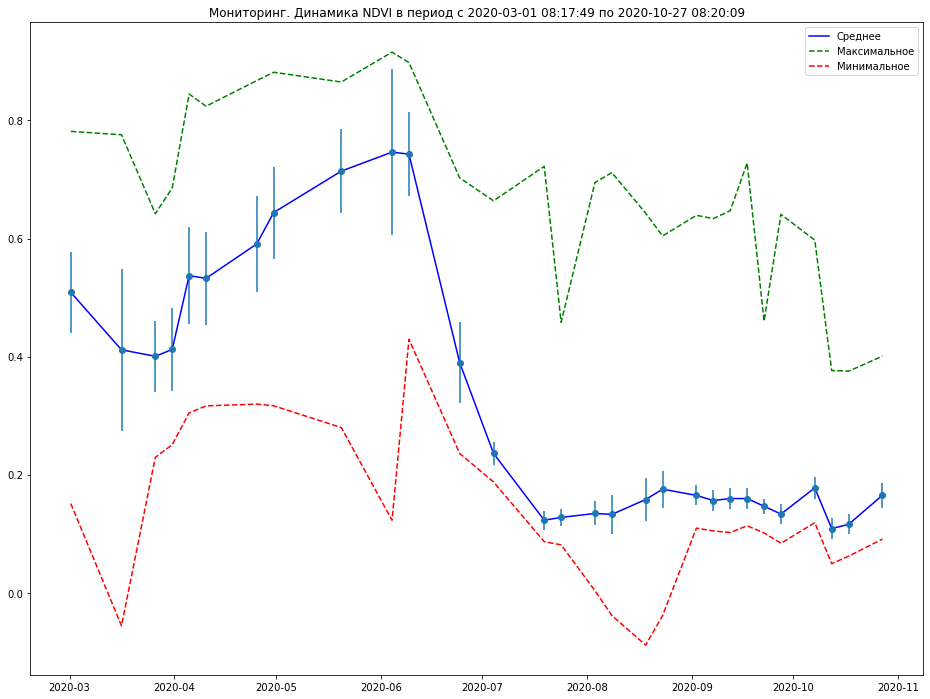

In [275]:
# 1. Строим график динамики средних значений
# Получаем список обработанных наборов за всё время
ndvi_datasets = os.listdir(processed_dir)

# Сортируем его - получится сортировка по дате
ndvi_datasets.sort()

# Открываем по очереди и извлекаем статистики
dates_list = []
mean_list = []
max_list = []
min_list = []
stdev_list = []

for dataset in ndvi_datasets:
    ds = gdal.Open(os.path.join(processed_dir,dataset))
    ndvi = ds.GetRasterBand(1).ReadAsArray()
    dates_list.append(datetime.strptime(dataset,'ndvi_%Y%m%dT%H%M%S.tif'))
    mean_list.append(np.nanmean(ndvi))
    max_list.append(np.nanmax(ndvi))
    min_list.append(np.nanmin(ndvi))
    stdev_list.append(np.nanstd(ndvi))

# Строим график
plt.rcParams['figure.figsize'] = [16, 12]
plt.close()
plt.plot(dates_list, mean_list, 'b-', label='Среднее')
plt.errorbar(dates_list, mean_list, stdev_list, linestyle='None', marker='o')
plt.plot(dates_list, max_list, 'g--', label='Максимальное')
plt.plot(dates_list, min_list, 'r--', label='Минимальное')
plt.legend()
plt.title('Мониторинг. Динамика NDVI в период с %s по %s' % (dates_list[0], dates_list[-1]))
plt.show()

### Извлечение информации из подготовленных данных в виде парада картинок

<ipython-input-277-24c77e827b85>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


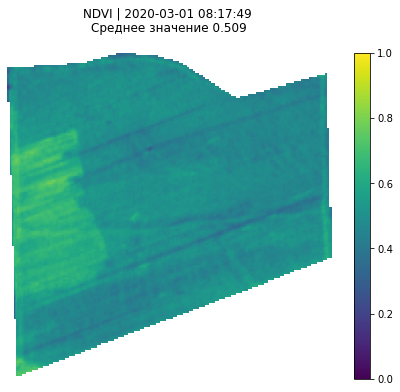

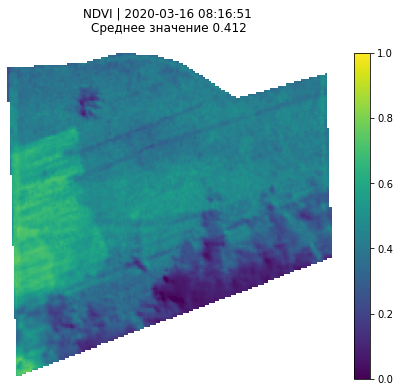

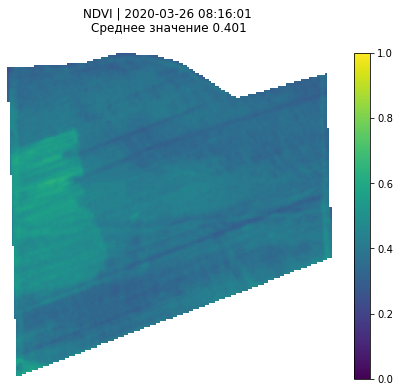

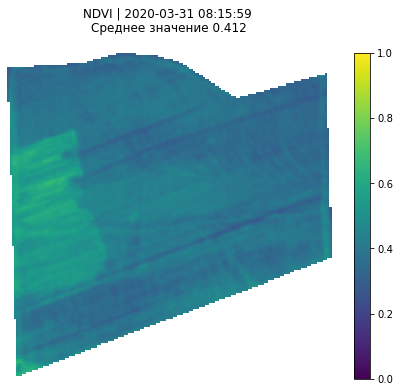

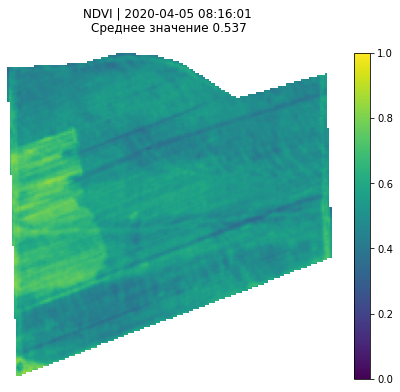

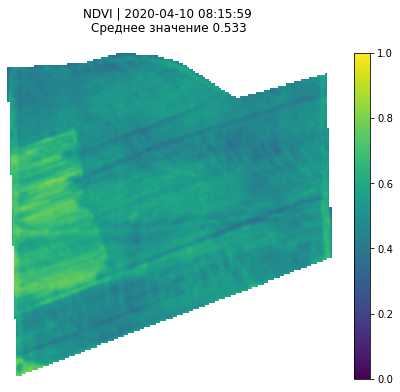

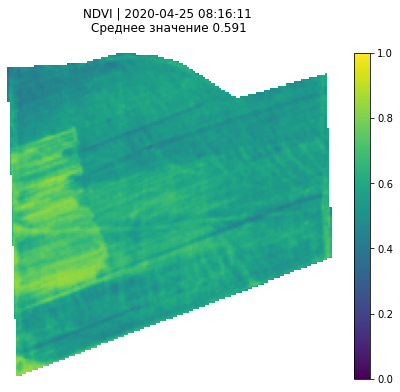

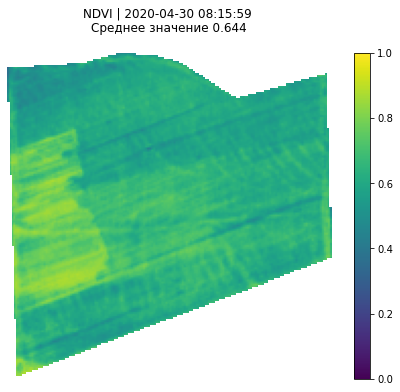

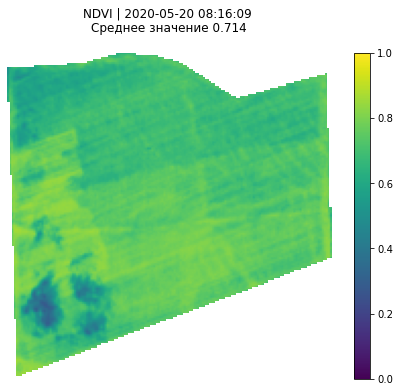

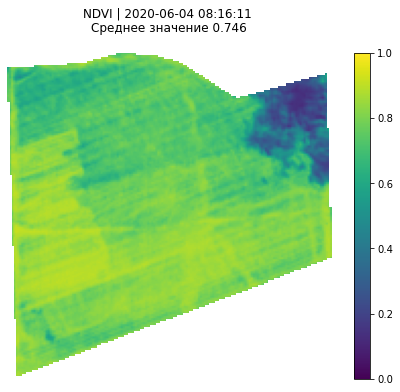

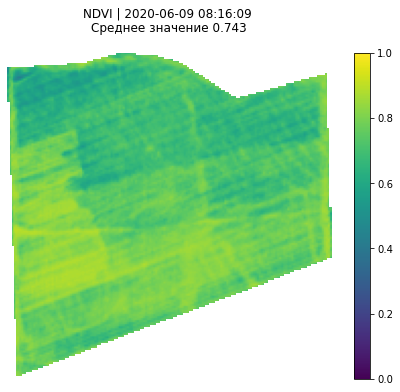

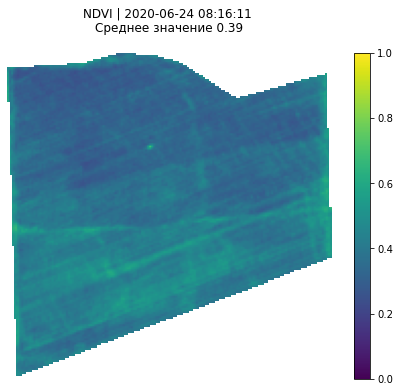

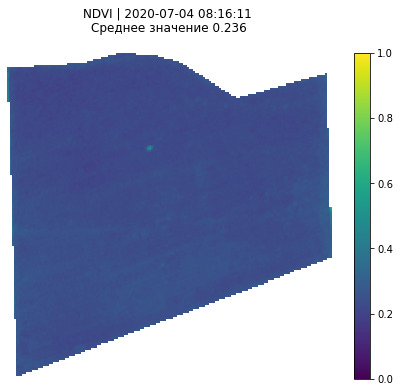

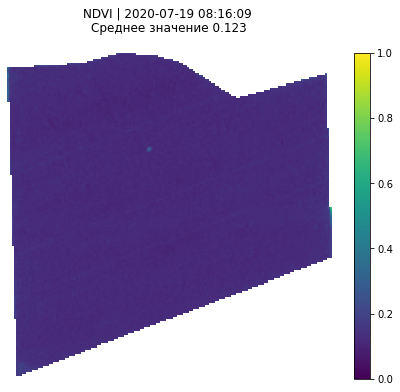

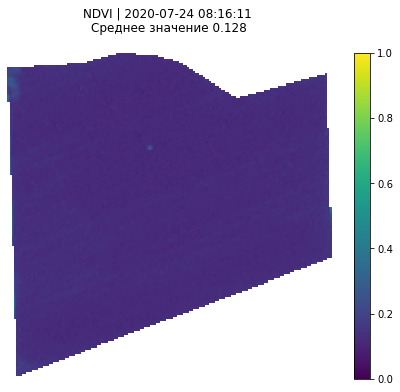

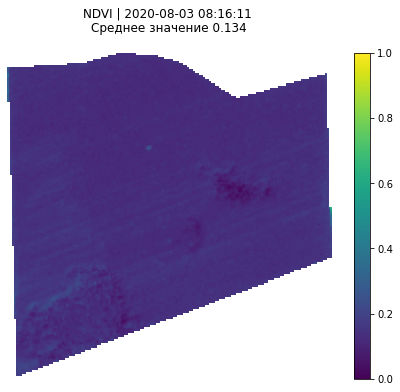

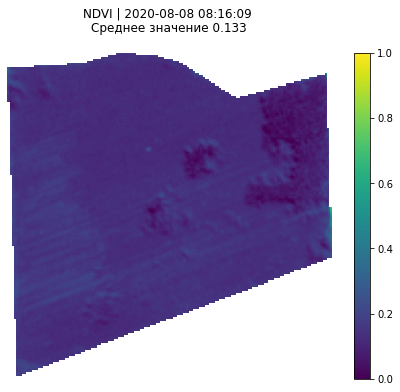

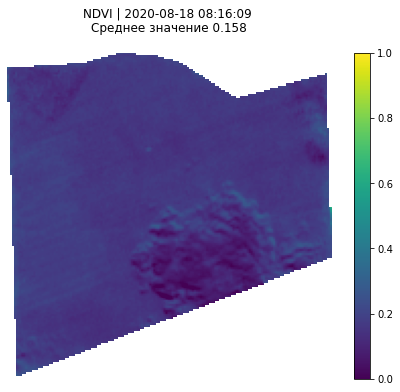

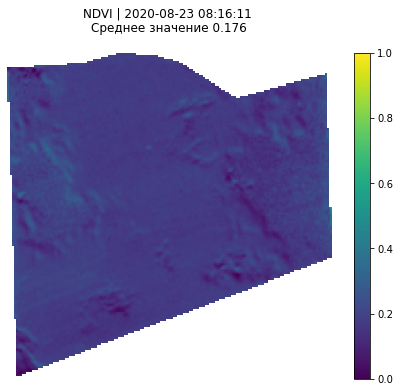

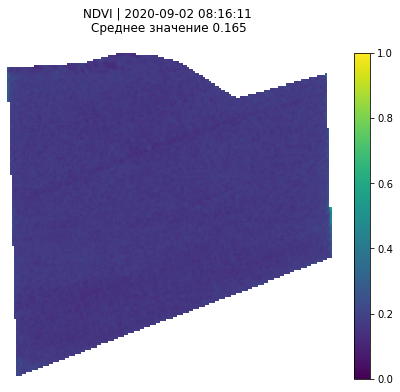

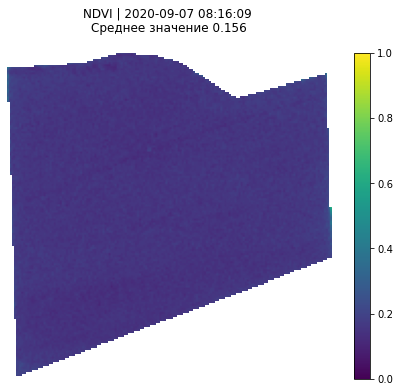

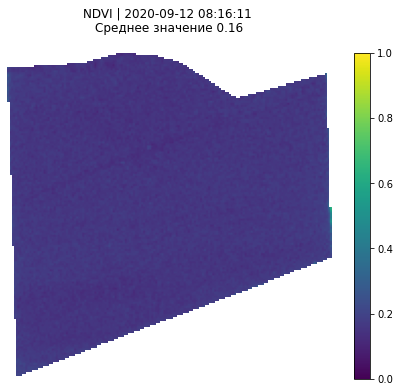

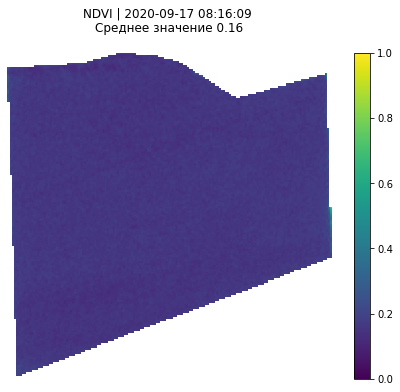

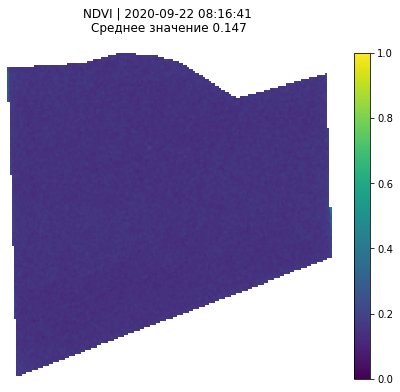

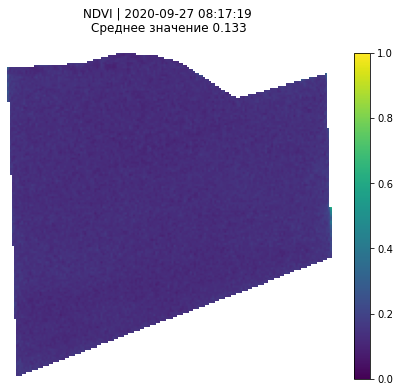

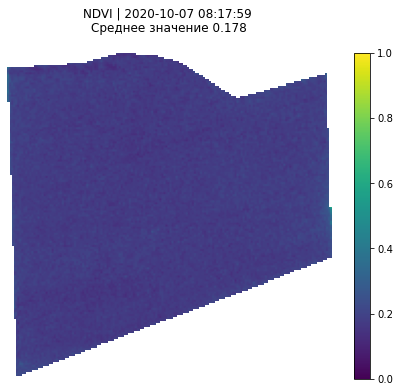

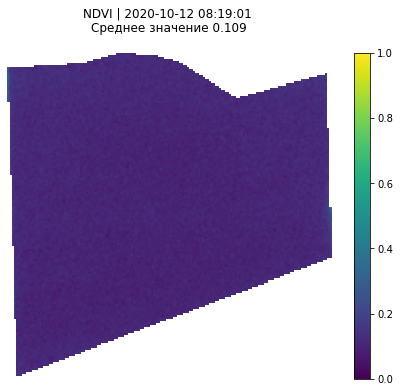

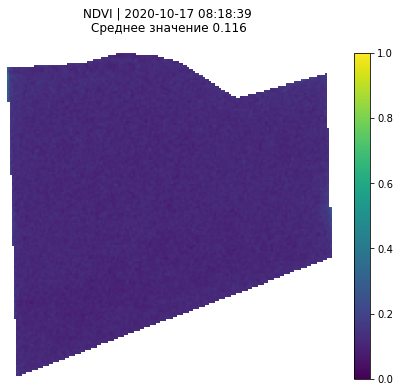

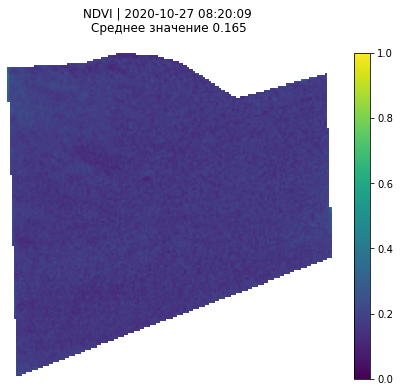

In [277]:
plt.rcParams['figure.figsize'] = [8, 6]
for dataset in ndvi_datasets:
    ds = gdal.Open(os.path.join(processed_dir,dataset))
    ndvi = ds.GetRasterBand(1).ReadAsArray()
    plt.figure()
    plt.imshow(ndvi, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('NDVI | %s \nСреднее значение %s\n' % (datetime.strptime(dataset,'ndvi_%Y%m%dT%H%M%S.tif'), round(np.nanmean(ndvi),3)))
    plt.colorbar()